<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/main/tutorial/2_waymo_official_tutorial/hj-waymo_official_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tutorial/2_waymo_official_tutorial/hj-waymo_official_tutorial.ipynb

# Waymo Open Dataset Motion Tutorial

https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial_motion.ipynb


## 튜토리얼 목차
- 데이터를 디코딩하고 해석하는 방법
- Tensorflow로 간단한 모델을 훈련시키는 방법

## 데이터셋 다운로드
- https://waymo.com/open/



## 패키지 설치
- https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb

In [ ]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master

In [6]:
%%capture
!pip3 install --upgrade pip
!pip3 install waymo-open-dataset-tf-2-6-0

## 데이터셋 로드
데이터셋의 크기가 커서 구글 드라이브에 업로드하였고, 해당 데이터를 로드해야 한다.

In [1]:
# 내 드라이브를 현재 위치에 가져오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [25]:
FILENAME = '/content/drive/MyDrive/waymo-od-dataset/tutorial/validation.tfrecord-00000-of-00150'

In [34]:
import math
import os
import uuid
import time

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf

from google.protobuf import text_format
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import motion_metrics_pb2


## Create Dataset

In [37]:
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for num_data, data in enumerate(dataset) :
  pass

num_data

269

- 해당 tfrecord 내부에는 269개의 데이터가 있다.

### 데이터셋 구조 파일(proto)을 이용하여 로드
- tfrecord는 압축된 형태로 존재한다. `TFRecordDataset`을 통해 데이터를 읽을 수 있지만, 그 전에 압축된 데이터를 해제할 수 있도록 구조 정의가 필요하다.

In [49]:
type(data)

tensorflow.python.framework.ops.EagerTensor

In [57]:
data.numpy()[:100]

b'\t\x00\x00\x00\x00\x00\x00\x00\x00\t,}\xe8\x82\xfa\x96\xb9?\t~R\xed\xd3\xf1\x98\xc9?\t333333\xd3?\t\xb5\xe0E_A\x9a\xd9?\t8\xbe\xf6\xcc\x92\x00\xe0?\t2\x03\x95\xf1\xef3\xe3?\t,H3\x16Mg\xe6?\t&\x8d\xd1:\xaa\x9a\xe9?\t \xd2o_\x07\xce\xec?\t\xff\xcfa\xbe\xbc\x00\xf0?\t'

In [53]:
from waymo_open_dataset.protos import scenario_pb2 
# Protocol Buffers (PB)
# 구글에서 개발한 경량 데이터 교환 형식 중 하나로, 프로그래밍 언어와 플랫폼 간의 데이터 통신에 사용

scenario = scenario_pb2.Scenario()
scenario.ParseFromString(data.numpy())

435428

In [39]:
scenario.scenario_id

'c12dd9b235799eb8'

## 데이터셋 구조

- scenario.proto
  - message ObjectState
  - message Track
  - message DynamicMapState
  - message RequiredPrediction
  - message Scenario
- map.proto
  - message Map
  - message DynamicState
  - message TrafficSignalLaneState
  - message MapFeature
  - message MapPoint
  - message BoundarySegment
  - message LaneNeighbor
  - message LaneCenter
  - message RoadEdge
  - message RoadLine
  - message StopSign
  - message Crosswalk
  - message SpeedBump

## TF(TensorFlow 데이터 포맷) Example sample 시각화

### 정적 map 데이터 출력 

In [74]:
def poly2position(poly) :
  x, y, z = [], [], []
  for point in poly :
    x.append(point.x)
    y.append(point.y)
    z.append(point.z)
  return x, y, z

In [77]:
def visualizationMap(ax, map_features) :
  for feature in map_features :
    lane_x, lane_y, lane_z = poly2position(feature.lane.polyline)
    ax.plot(lane_x, lane_y, '-', c='#d6d6d6', lw=3) # 도로부분이라서 연한 회색
    
    road_line_x, road_line_y, road_line_z = poly2position(feature.road_line.polyline)
    ax.plot(road_line_x, road_line_y, '--', c='gray') # 차선이라서 일단 회색 대시 선
    
    road_edge_x, road_edge_y, road_edge_z = poly2position(feature.road_edge.polyline)
    ax.plot(road_edge_x, road_edge_y, '-', c='black') # 엣지 부분은 검은 실선
    
    for point in [feature.stop_sign.position]:
        pass #ax.plot(point.x, point.y, marker='o', c='red', ms=10) # 데이터가 좀 이상함,,,
    
    crosswalk_x, crosswalk_y, crosswalk_z = poly2position(feature.crosswalk.polygon)
    ax.plot(crosswalk_x, crosswalk_y, '-', c='#f1f289', lw=3)
    
    speed_bump_x, speed_bump_y, speed_bump_z = poly2position(feature.speed_bump.polygon)
    ax.plot(speed_bump_x, speed_bump_y, '-', c='#fab6e6', lw=3)

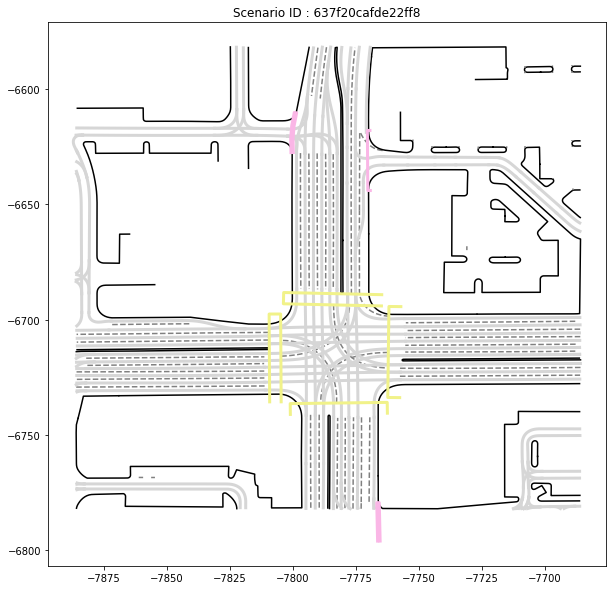

In [78]:
for data in dataset:
  proto_string = data.numpy()
  scenario = scenario_pb2.Scenario()
  scenario.ParseFromString(proto_string)

  break

fig, ax = plt.subplots(figsize=(10,10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

visualizationMap(ax, scenario.map_features)